In [1]:
import os
import pandapower as pp
import polars as pl
from polars import col as c
import pandapower.networks as pn
# from pipelines.dig_a_plan_slack_v import DigAPlan

from data_display.grid_plotting import plot_grid_from_pandapower
from data_display.output_processing import compare_dig_a_plan_with_pandapower
from data_connector import pandapower_to_dig_a_plan_schema


from pipelines.dig_a_plan_d_model import DigAPlan
import matplotlib.pyplot as plt

os.chdir(os.getcwd().replace("/src", ""))
os.environ['GRB_LICENSE_FILE'] = os.environ["HOME"] + "/gurobi_license/gurobi.lic"


In [2]:
LOAD_FACTOR = 0.01
GEN_FACTOR = 0.01
net = pp.from_pickle(".cache/input_data/mv_example_oberrhein.p")


# net = pp.from_pickle(".cache/input_data/mv_example.p")

In [3]:

net["load"]["p_mw"] = net["load"]["p_mw"]*LOAD_FACTOR
net["load"]["q_mvar"] = net["load"]["q_mvar"]*LOAD_FACTOR

net["sgen"]["p_mw"] = net["sgen"]["p_mw"]*GEN_FACTOR
net["sgen"]["q_mvar"] = net["sgen"]["q_mvar"]*GEN_FACTOR
# net["trafo"]["vn_hv_kv"] = [110., 110.]
# # net["trafo"]["vn_lv_kv"] = [17.8, 21.8]
# net["trafo"]["vn_lv_kv"] = [17.8, 21.5]

# line_list= [6, 9, 11, 13, 16]

net["line"].loc[:, "max_i_ka"] = 1e9

In [4]:
grid_data = pandapower_to_dig_a_plan_schema(net=net, s_base=1e6)

dig_a_plan: DigAPlan = DigAPlan(
    verbose= True, big_m = 1e4, penalty_cost = 1e1
)

dig_a_plan.add_grid_data(**grid_data)
dig_a_plan.solve_models_pipeline(max_iters = 200)


Master obj: 0, Slave obj: 0 and Gap: 1e6:   0%|          | 0/200 [00:00<?, ?it/s]2025-06-23 09:42:42 B01BPC15 pipelines.dig_a_plan_d_model[29835] WARNING 
Master model did not converge: infeasible


In [5]:
grid_data = pandapower_to_dig_a_plan_schema(net=net, s_base=1e6)
grid_data["edge_data"].filter(c("type")== "transformer")
grid_data["node_data"]

cn_fk,node_id,v_base,p_node_pu,q_node_pu,v_node_sqr_pu,s_base,i_base,type
str,i32,f64,f64,f64,f64,f64,f64,str
"""Bus 0""",0,20000.0,0.0027785,0.000812,null,1e6,28.867513,"""pq"""
"""Bus 1""",1,20000.0,0.001584,0.000508,null,1e6,28.867513,"""pq"""
"""Bus 2""",2,20000.0,0.001737,0.000508,null,1e6,28.867513,"""pq"""
"""Bus 3""",3,20000.0,0.001737,0.000508,null,1e6,28.867513,"""pq"""
"""Bus 4""",4,20000.0,0.001584,0.000508,null,1e6,28.867513,"""pq"""
…,…,…,…,…,…,…,…,…
"""Bus 637""",637,20000.0,0.0,0.0,null,1e6,28.867513,"""pq"""
"""Bus 638""",638,20000.0,0.0,0.0,null,1e6,28.867513,"""pq"""
"""Bus 639""",639,20000.0,0.0,0.0,null,1e6,28.867513,"""pq"""


In [6]:
grid_data["node_data"]

cn_fk,node_id,v_base,p_node_pu,q_node_pu,v_node_sqr_pu,s_base,i_base,type
str,i32,f64,f64,f64,f64,f64,f64,str
"""Bus 0""",0,20000.0,0.0027785,0.000812,null,1e6,28.867513,"""pq"""
"""Bus 1""",1,20000.0,0.001584,0.000508,null,1e6,28.867513,"""pq"""
"""Bus 2""",2,20000.0,0.001737,0.000508,null,1e6,28.867513,"""pq"""
"""Bus 3""",3,20000.0,0.001737,0.000508,null,1e6,28.867513,"""pq"""
"""Bus 4""",4,20000.0,0.001584,0.000508,null,1e6,28.867513,"""pq"""
…,…,…,…,…,…,…,…,…
"""Bus 637""",637,20000.0,0.0,0.0,null,1e6,28.867513,"""pq"""
"""Bus 638""",638,20000.0,0.0,0.0,null,1e6,28.867513,"""pq"""
"""Bus 639""",639,20000.0,0.0,0.0,null,1e6,28.867513,"""pq"""


In [7]:
grid_data = pandapower_to_dig_a_plan_schema(net=net, s_base=1e9)
grid_data["edge_data"].filter(c("type")== "transformer")
grid_data["node_data"]

cn_fk,node_id,v_base,p_node_pu,q_node_pu,v_node_sqr_pu,s_base,i_base,type
str,i32,f64,f64,f64,f64,f64,f64,str
"""Bus 0""",0,20000.0,0.000003,8.1223e-7,null,1.0000e9,28867.513459,"""pq"""
"""Bus 1""",1,20000.0,0.000002,5.0765e-7,null,1.0000e9,28867.513459,"""pq"""
"""Bus 2""",2,20000.0,0.000002,5.0765e-7,null,1.0000e9,28867.513459,"""pq"""
"""Bus 3""",3,20000.0,0.000002,5.0765e-7,null,1.0000e9,28867.513459,"""pq"""
"""Bus 4""",4,20000.0,0.000002,5.0765e-7,null,1.0000e9,28867.513459,"""pq"""
…,…,…,…,…,…,…,…,…
"""Bus 637""",637,20000.0,0.0,0.0,null,1.0000e9,28867.513459,"""pq"""
"""Bus 638""",638,20000.0,0.0,0.0,null,1.0000e9,28867.513459,"""pq"""
"""Bus 639""",639,20000.0,0.0,0.0,null,1.0000e9,28867.513459,"""pq"""


In [8]:
dig_a_plan.solve_models_pipeline(max_iters = 200)

Master obj: 0, Slave obj: 0 and Gap: 1e6:   0%|          | 0/200 [00:00<?, ?it/s]2025-06-23 09:42:43 B01BPC15 pipelines.dig_a_plan_d_model[29835] WARNING 
Master model did not converge: infeasible


In [9]:
dig_a_plan.extract_switch_status()

{'Switch 0': False,
 'Switch 1': False,
 'Switch 2': False,
 'Switch 3': False,
 'Switch 4': False,
 'Switch 5': False,
 'Switch 6': False,
 'Switch 7': False,
 'Switch 8': False,
 'Switch 9': False,
 'Switch 10': False,
 'Switch 11': False,
 'Switch 12': False,
 'Switch 13': False,
 'Switch 15': False,
 'Switch 16': False,
 'Switch 17': False,
 'Switch 18': False,
 'Switch 19': False,
 'Switch 20': False,
 'Switch 21': False,
 'Switch 22': False,
 'Switch 23': False,
 'Switch 24': False,
 'Switch 25': False,
 'Switch 26': False,
 'Switch 27': False,
 'Switch 28': False,
 'Switch 29': False,
 'Switch 30': False,
 'Switch 31': False,
 'Switch 32': False,
 'Switch 33': False,
 'Switch 35': False,
 'Switch 36': False,
 'Switch 37': False,
 'Switch 38': False,
 'Switch 39': False,
 'Switch 40': False,
 'Switch 41': False,
 'Switch 42': False,
 'Switch 43': False,
 'Switch 44': False,
 'Switch 45': False,
 'Switch 46': False,
 'Switch 47': False,
 'Switch 49': False,
 'Switch 50': False,
 '

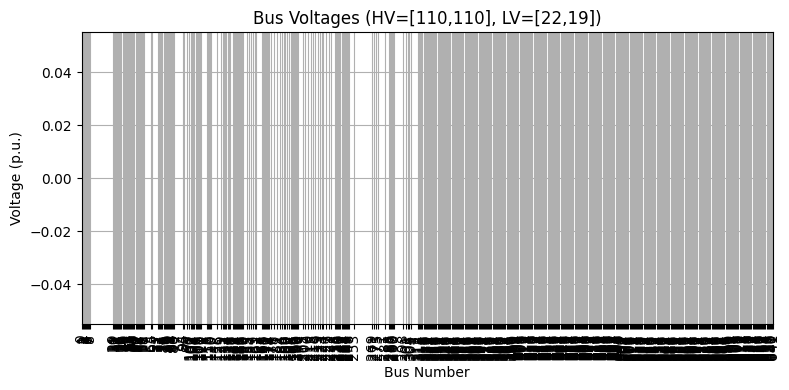

In [10]:
# Extract voltages
v_df: pl.DataFrame = dig_a_plan.extract_node_voltage()    # Polars DF with node_id & v_pu
v_pd = v_df.to_pandas().sort_values("node_id")    # convert to pandas & sort

# Plot
plt.figure(figsize=(8,4))
plt.plot(
    v_pd["node_id"],
    v_pd["v_pu"],
    marker='o',
    linestyle='-'
)
plt.xlabel("Bus Number")
plt.ylabel("Voltage (p.u.)")
plt.title("Bus Voltages (HV=[110,110], LV=[22,19])")
plt.xticks(v_pd["node_id"], rotation=90)   # show every bus ID on the x-axis
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
compare_dig_a_plan_with_pandapower(dig_a_plan=dig_a_plan, net=net)
plot_grid_from_pandapower(net=net)

KeyError: 'Switch 14'